# <center>How to use state of the art Deep Learning models in your project</center>
<center><img src="images/inception.png" width=1024></center>

# What is Deep Learning? 

![Deep Network](images/deep-net.png)

# Why it's so popular?
![Speech Recognition progress](images/speech-progress.png)
[Li Deng]

![Image classification progress](images/imagenet-progress.png)
[Russakovsky]

# Face recognition by using embeddings (FaceNet)

![Representation](images/repr.png)
[Socher et al]

# Model structure

![Model structure](images/model-structure.png)
[Schroff et al]

# Triplet loss

![Triplet loss](images/triplet-loss.png)
![Triplet loss formula](images/triplet-loss-formula.png)
[Schroff et al]

# Let's take Google Lenet (Inception) from model zoo

![Google Lenet](images/inception-arch.png)
[Szegedy et. al]

# Transfer learning

## - Pretrained model is a good starting point, some knowledge is already included

## - Access to the state of the art research in your domain

## - You save a lot of time on training, only need to fine tune

# Google Lenet architecture

In [58]:
# BLVC Googlenet, model from the paper:
# "Going Deeper with Convolutions"
# Original source:
# https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet
# License: unrestricted use

# Download pretrained weights from:
# https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/blvc_googlenet.pkl

import numpy as np
import matplotlib 
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as LRNLayer
from batch_norm import batch_norm

EMBED_DIM = 2
HEIGHT = 96
WIDTH = 96
C = 1

![Inception layer](images/inception-layer.png)

In [2]:
def build_inception_module(name, input_layer, nfilters):
    # nfilters: (pool_proj, 1x1, 3x3_reduce, 3x3, 5x5_reduce, 5x5)
    net = {}
    net['pool'] = PoolLayer(input_layer, pool_size=3, stride=1, pad=1, name='{}/{}'.format(name, 'pool'))
    net['pool_proj'] = ConvLayer(net['pool'], nfilters[0], 1, name='{}/{}'.format(name, 'pool_proj'))

    net['1x1'] = ConvLayer(input_layer, nfilters[1], 1, name='{}/{}'.format(name, '1x1'))

    net['3x3_reduce'] = ConvLayer(input_layer, nfilters[2], 1, name='{}/{}'.format(name, '3x3_reduce'))
    net['3x3'] = ConvLayer(net['3x3_reduce'], nfilters[3], 3, pad=1, name='{}/{}'.format(name, '3x3'))

    net['5x5_reduce'] = ConvLayer(input_layer, nfilters[4], 1, name='{}/{}'.format(name, '5x5_reduce'))
    net['5x5'] = ConvLayer(net['5x5_reduce'], nfilters[5], 5, pad=2, name='{}/{}'.format(name, '5x5'))

    net['output'] = ConcatLayer([
        net['1x1'],
        net['3x3'],
        net['5x5'],
        net['pool_proj'],
        ])
        
    return {'{}/{}'.format(name, k): v for k, v in net.items()}

In [3]:
def inception_modules(net, input_name):
    net.update(build_inception_module('inception_3a',
                                      net[input_name],
                                      [32, 64, 96, 128, 16, 32]))
    net.update(build_inception_module('inception_3b',
                                      net['inception_3a/output'],
                                      [64, 128, 128, 192, 32, 96]))
    
    net['pool3/3x3_s2'] = PoolLayer(net['inception_3b/output'], pool_size=3, stride=2, name='pool3/3x3_s2')

    net.update(build_inception_module('inception_4a',
                                      net['pool3/3x3_s2'],
                                      [64, 192, 96, 208, 16, 48]))
    net.update(build_inception_module('inception_4b',
                                      net['inception_4a/output'],
                                      [64, 160, 112, 224, 24, 64]))
    net.update(build_inception_module('inception_4c',
                                      net['inception_4b/output'],
                                      [64, 128, 128, 256, 24, 64]))
    net.update(build_inception_module('inception_4d',
                                      net['inception_4c/output'],
                                      [64, 112, 144, 288, 32, 64]))
    net.update(build_inception_module('inception_4e',
                                      net['inception_4d/output'],
                                      [128, 256, 160, 320, 32, 128]))
    
    net['pool4/3x3_s2'] = PoolLayer(net['inception_4e/output'], pool_size=3, stride=2, name='pool4/3x3_s2')

    net.update(build_inception_module('inception_5a',
                                      net['pool4/3x3_s2'],
                                      [128, 256, 160, 320, 32, 128]))
    net.update(build_inception_module('inception_5b',
                                      net['inception_5a/output'],
                                      [128, 384, 192, 384, 48, 128]))

    net['pool5/7x7_s1'] = GlobalPoolLayer(net['inception_5b/output'], name='pool5/7x7_s1')
    
    return net

def build_network(input_var=None):
    net = {}
    net['input'] = InputLayer((None, C, HEIGHT, WIDTH), input_var=input_var, name='input')
    net['conv1/7x7_s2'] = ConvLayer(net['input'], 64, 7, stride=2, pad=3, name='conv1/7x7_s2')
    net['pool1/3x3_s2'] = PoolLayer(net['conv1/7x7_s2'], pool_size=3, stride=2, ignore_border=False, name='pool1/3x3_s2')
    net['pool1/norm1'] = LRNLayer(net['pool1/3x3_s2'], alpha=0.00002, k=1, name='pool1/norm1')
    net['conv2/3x3_reduce'] = ConvLayer(net['pool1/norm1'], 64, 1, name='conv2/3x3_reduce')
    net['conv2/3x3'] = ConvLayer(net['conv2/3x3_reduce'], 192, 3, pad=1, name='conv2/3x3')
    net['conv2/norm2'] = LRNLayer(net['conv2/3x3'], alpha=0.00002, k=1, name='conv2/norm2')
    net['pool2/3x3_s2'] = PoolLayer(net['conv2/norm2'], pool_size=3, stride=2, name='pool2/3x3_s2')

    # Create inception modules
    net = inception_modules(net, 'pool2/3x3_s2')
    
    # Change output to be embedding layer
    net['fc'] = DenseLayer(net['pool5/7x7_s1'],
                           num_units=EMBED_DIM,
                           nonlinearity=lasagne.nonlinearities.identity,
                           W=lasagne.init.Uniform(),
                           name='fc')
    net['out'] = batch_norm(net['fc'])
    
    return net

# How to load pretrained weights into modified network?

## - Print out weigths and defined layers

In [4]:
import cPickle
from tabulate import tabulate

def compare_layers(net, param_vals):
    names = lasagne.layers.get_all_params(net)
    params = lasagne.layers.get_all_param_values(net)
    layers = {'Layer name': [], 'Layer shape': [], 'Params shape': []}
    for i in range(len(params)):
        layers['Layer name'].append(names[i])
        layers['Layer shape'].append(params[i].shape)
        if (i < len(param_vals)):
            layers['Params shape'].append(param_vals[i].shape)
        
    print tabulate(layers, headers="keys")

net = build_network(T.tensor4('inputs'))['out']
googleLenet = cPickle.load(open('models/blvc_googlenet.pkl'))['param values']
compare_layers(net, googleLenet)

Params shape      Layer shape       Layer name
----------------  ----------------  -------------------------
(64, 3, 7, 7)     (64, 1, 7, 7)     conv1/7x7_s2.W
(64,)             (64,)             conv1/7x7_s2.b
(64, 64, 1, 1)    (64, 64, 1, 1)    conv2/3x3_reduce.W
(64,)             (64,)             conv2/3x3_reduce.b
(192, 64, 3, 3)   (192, 64, 3, 3)   conv2/3x3.W
(192,)            (192,)            conv2/3x3.b
(64, 192, 1, 1)   (64, 192, 1, 1)   inception_3a/1x1.W
(64,)             (64,)             inception_3a/1x1.b
(96, 192, 1, 1)   (96, 192, 1, 1)   inception_3a/3x3_reduce.W
(96,)             (96,)             inception_3a/3x3_reduce.b
(128, 96, 3, 3)   (128, 96, 3, 3)   inception_3a/3x3.W
(128,)            (128,)            inception_3a/3x3.b
(16, 192, 1, 1)   (16, 192, 1, 1)   inception_3a/5x5_reduce.W
(16,)             (16,)             inception_3a/5x5_reduce.b
(32, 16, 5, 5)    (32, 16, 5, 5)    inception_3a/5x5.W
(32,)             (32,)             inception_3a/5x5.b
(32, 

In [5]:
def set_network_params(net, param_vals):
    param_names = []
    params = lasagne.layers.get_all_param_values(net)
    names = lasagne.layers.get_all_params(net)
    print "Setting pretrained weights for the network"
    
    # Reset layers where shape is not the same
    new_params = []
    for i in xrange(len(params)):
        param_names.append(names[i])
        if (i >= len(param_vals) or params[i].shape != param_vals[i].shape):
            print "Resetting parameters for layer %s at index %s" % (names[i], i)
            new_params.append(np.random.random(params[i].shape).astype(theano.config.floatX))
        else:
            new_params.append(param_vals[i])
    
    lasagne.layers.set_all_param_values(net, new_params)
    return param_names

# Define forwardprop, backprop, triplet loss and optimization

In [54]:
from lasagne.regularization import regularize_network_params, l2
from collections import OrderedDict

def tripletLoss(pred, margin):
    a = pred[0::3]
    p = pred[1::3]
    n = pred[2::3]
    d1 = T.sum((a - p)**2, axis=-1)
    d2 = T.sum((a - n)**2, axis=-1)
    return T.mean(T.maximum(0, d1 + margin - d2))

def create_network(margin, lr, mom, decay):
    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    lr_var = theano.shared(np.array(lr, dtype=theano.config.floatX))

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    new_params = []
    network = build_network(input_var)
    googleLenet = cPickle.load(open('models/blvc_googlenet.pkl'))['param values']
    new_params = set_network_params(network['out'], googleLenet)
    
    # Forward propagation
    pred = lasagne.layers.get_output(network['out'])
    
    # Calculate triplet loss function and apply regularization 
    loss = tripletLoss(pred, margin)
    l2_penalty = regularize_network_params(network['out'], l2) * decay
    loss = loss + l2_penalty

    # Backward propagation with per layer update
    updates = OrderedDict()
    lr_mult = {name: 100.0 for name in new_params}
    for name, layer in network.items():
        layer_params = layer.get_params(trainable=True)
        layer_lr = np.array(lr_mult.get(name, 1.0) * lr_var.get_value(), dtype=theano.config.floatX)
        layer_updates = lasagne.updates.nesterov_momentum(loss, layer_params, learning_rate=layer_lr, momentum=mom)
        updates.update(layer_updates)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_func = theano.function([input_var], [loss, pred[0::3]], updates=updates)  
    forward_func = theano.function([input_var], pred)
    test_func = theano.function([input_var], tripletLoss(pred, margin))
    
    return network, train_func, test_func, forward_func, lr_var

## - Set leraning rate low to fine tune the network 
## - Increase learning rate up to 10x or 100x in modified layers

# Load dataset

In [7]:
import os
import pandas as pd
from PIL import Image

def resize(data):
    images = np.zeros((data.shape[0], C, HEIGHT, WIDTH), dtype=np.uint8)
    for i, image in enumerate(data):
        im = Image.fromarray(image.astype(np.uint8)) if C == 3 else Image.fromarray(image).convert('L')
        im = im.resize((HEIGHT, WIDTH), Image.BICUBIC)
        images[i,:,:,:] = np.array(im).reshape((-1, C, HEIGHT, WIDTH))
    return images

def load_mnist():
    dirname = os.path.abspath('data')    
    train_csv = os.path.join(dirname, 'digits-train.csv')
    train = pd.read_csv(train_csv, nrows=16000).as_matrix()
    train_images = train[:, 1:].reshape((-1, 28, 28)).astype(np.uint8)
    train_images = resize(train_images)
    
    print("Total train dataset size:")
    print("  samples: %d" % train_images.shape[0])
    print("  image size: %d x %d" % (train_images.shape[2], train_images.shape[3]))
    print("  unique classes: %d" % len(set(train[:, 0])))
    
    return train_images, train[:, 0]

In [8]:
images, targets = load_mnist()

Total train dataset size:
  samples: 16000
  image size: 96 x 96
  unique classes: 10


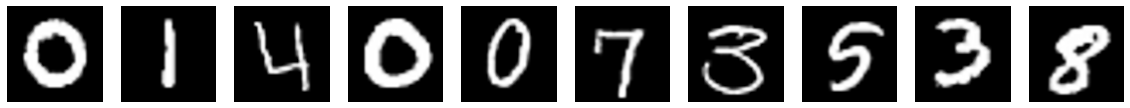

In [9]:
fig = plt.figure(figsize=(20,10))
num = 10
for i in range(1, num + 1):
    f = fig.add_subplot(1,num,i)
    f.set_xticklabels([])
    f.set_yticklabels([])
    plt.imshow(images[i, 0], cmap=plt.cm.Greys_r)
plt.show()

# Split on train and test

In [12]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=777)

# Normalize images

In [13]:
mean_img = np.mean(X_train).astype(theano.config.floatX)
std_img = np.std(X_train).astype(theano.config.floatX)
X_train = (X_train.astype(theano.config.floatX) - mean_img) / std_img
X_test = (X_test.astype(theano.config.floatX) - mean_img) / std_img

# Generate test triplets

In [14]:
def random_triplet(batch_idx, images, targets, random_state=None):
    batch_input = images[batch_idx]
    batch_targets = targets[batch_idx]
    
    #
    # Sample from the different class
    #
    if random_state is not None:
        np.random.seed(random_state)
    diff_idx = np.array([np.random.choice(np.where(targets != t)[0], 1) for t in batch_targets])
    diff_idx = np.ravel(diff_idx)
    
    #
    # Sample from the same class 
    #
    if random_state is not None:
        np.random.seed(random_state)
    same_idx = np.array([np.random.choice(np.where(targets == t)[0], 1) for t in batch_targets])
    same_idx = np.ravel(same_idx)
    
    assert(batch_idx.shape == same_idx.shape)
    assert(batch_idx.shape == diff_idx.shape)
    return batch_idx, same_idx, diff_idx

In [15]:
def fill_triplet_batch(batch_arr, im, triplet_idx):
    original, same, diff = triplet_idx
    batch_arr[0::3] = im[original].astype(theano.config.floatX)
    batch_arr[1::3] = im[same].astype(theano.config.floatX)
    batch_arr[2::3] = im[diff].astype(theano.config.floatX)
    return batch_arr

In [16]:
train_num = y_train.shape[0]
test_num = y_test.shape[0]
test_triplet = random_triplet(np.arange(y_test.shape[0]), X_test, y_test, random_state=777)
test_inputs = np.empty((y_test.shape[0] * 3, C, HEIGHT, WIDTH), dtype=theano.config.floatX)
fill_triplet_batch(test_inputs, X_test, test_triplet)
test_inputs.shape

(9600, 1, 96, 96)

# Compile neural network and load params

In [60]:
MARGIN = 0.2
LEARNING_RATE = 5.0e-4
MOMENTUM = 0.9
DECAY = 1.0e-4

network, train_func, test_func, forward_func, lr_var = create_networ(MARGIN, LEARNING_RATE, MOMENTUM, DECAY)

Building model and compiling functions...
Setting pretrained weights for the network
Resetting parameters for layer conv1/7x7_s2.W at index 0
Resetting parameters for layer fc.W at index 114
Resetting parameters for layer mean at index 115
Resetting parameters for layer std at index 116
Resetting parameters for layer beta at index 117
Resetting parameters for layer gamma at index 118


# Plot embedding space before training

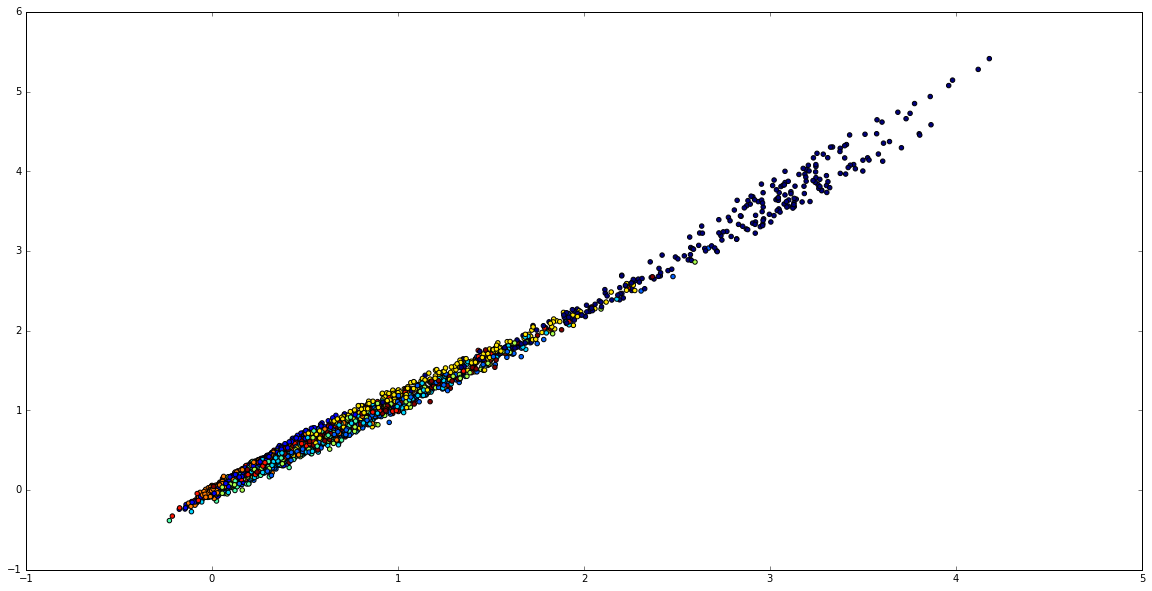

In [61]:
test_emb = forward_fun(X_test)
plt.figure(figsize=(20,10))
plt.scatter(test_emb[:, 0], test_emb[:, 1], c=y_test)

# Start training

In [22]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

def hardest_triplet(emb, batch_idx, images, targets):
    batch_input = images[batch_idx]
    batch_targets = targets[batch_idx]
    original = emb[batch_idx]
    
    #
    # Find hardest negative samples and attach them to the batch
    #
    dist = cdist(original, original, 'euclidean')  # Distance matrix
    same = np.tile(batch_targets, (batch_targets.shape[0], 1)) == batch_targets.reshape((batch_targets.shape[0], -1))
    neg_dist = np.ma.array(dist, mask=same)  # Mask same classes
    neg_dist_idx = neg_dist.argmin(axis=1)  # Find hardest to distingush
    diff_idx = batch_idx[neg_dist_idx]
    
    #
    # Find examples from the same class for each sample
    # Constraint distance to the same class example to be less then distance to the hardest negative example.
    same_idx = np.array([], dtype=np.int)
    for i, t in enumerate(batch_targets): 
        pos_idx = np.where(targets == t)[0]
        hard_neg_dist = euclidean(original[i], emb[diff_idx][i])
        same_dist = np.ravel(cdist(original[i].reshape(-1, emb.shape[1]), emb[pos_idx]))
        same_idx = np.append(same_idx, pos_idx[np.random.choice(np.where(same_dist < hard_neg_dist)[0], 1)])
    
    assert(np.all(np.diag(cdist(emb[batch_idx], emb[same_idx])) < np.diag(cdist(emb[batch_idx], emb[diff_idx]))))
    assert(batch_idx.shape == same_idx.shape)
    assert(batch_idx.shape == diff_idx.shape)
    return batch_idx, same_idx, diff_idx

In [62]:
import time

BATCH_SIZE = 100
NUM_EPOCH = 100
DISPLAY = 1

test_loss_stats = []
chunk_size = 3 * 512
inputs = np.empty((BATCH_SIZE * 3, C, HEIGHT, WIDTH), dtype=theano.config.floatX)
emb = np.random.normal(0, 0.1, (y_train.shape[0], EMBED_DIM))

def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        
        yield np.array(excerpt, dtype=np.int)

def chunker(seq, win, step, dropend=False): 
    if (dropend):
        return (seq[pos:pos + win] for pos in xrange(0, len(seq), step) if len(seq) - pos >= win)
    else:
        return (seq[pos:pos + win] for pos in xrange(0, len(seq), step))

for epoch in range(1, NUM_EPOCH + 1):            
    train_err = []
    test_err = []
    start_time = time.time()
    
    # In each epoch, we do a full pass over the training data
    for batch_idx in iterate_minibatches(X_train, y_train, BATCH_SIZE):
        original, same, diff = hardest_triplet(emb, batch_idx, X_train, y_train)
        fill_triplet_batch(inputs, X_train, (original, same, diff))
        loss, emb[original] = train_func(inputs)
        train_err.append(loss)

    # Reduce learning rate
    lr_var.set_value(lr_var.get_value() * np.float32(0.98))

    # Update embeding layer after epoch
    for n, chunk in enumerate(chunker(range(y_train.shape[0]), chunk_size, chunk_size)):
        emb[chunk] = forward_func(X_train[chunk])    

    # Then we test on the test set and print the results:
    if epoch == 1 or epoch % DISPLAY == 0 or epoch == NUM_EPOCH:
        for n, chunk in enumerate(chunker(range(test_inputs.shape[0]), chunk_size, chunk_size)):  
            err = test_func(test_inputs[chunk])
            test_err.append(err)
        
        print "Epoch %s of %s took %s" % (epoch, NUM_EPOCH, time.time() - start_time)
        print "  test error:\t\t%s" % np.mean(test_err)
        test_loss_stats.append(np.mean(test_err))

Epoch 1 of 100 took 135.960004091
  test error:		0.0926664
Epoch 2 of 100 took 135.756663084
  test error:		0.103369
Epoch 3 of 100 took 135.747513056
  test error:		0.0756744
Epoch 4 of 100 took 135.737343073
  test error:		0.0929309
Epoch 5 of 100 took 135.770941019
  test error:		0.0648166
Epoch 6 of 100 took 135.741641998
  test error:		0.095853
Epoch 7 of 100 took 135.76366806
  test error:		0.0621491
Epoch 8 of 100 took 135.746031046
  test error:		0.09177
Epoch 9 of 100 took 135.730754137
  test error:		0.0555191
Epoch 10 of 100 took 135.757776976
  test error:		0.0587721
Epoch 11 of 100 took 135.752410889
  test error:		0.0436611
Epoch 12 of 100 took 135.761996984
  test error:		0.0499238
Epoch 13 of 100 took 135.763870001
  test error:		0.0393155
Epoch 14 of 100 took 135.756757021
  test error:		0.0353526
Epoch 15 of 100 took 135.802560806
  test error:		0.0269117
Epoch 16 of 100 took 135.796895027
  test error:		0.0274468
Epoch 17 of 100 took 135.799632072
  test error:		0.02

## Plot test loss over epohs

<function matplotlib.pyplot.show>

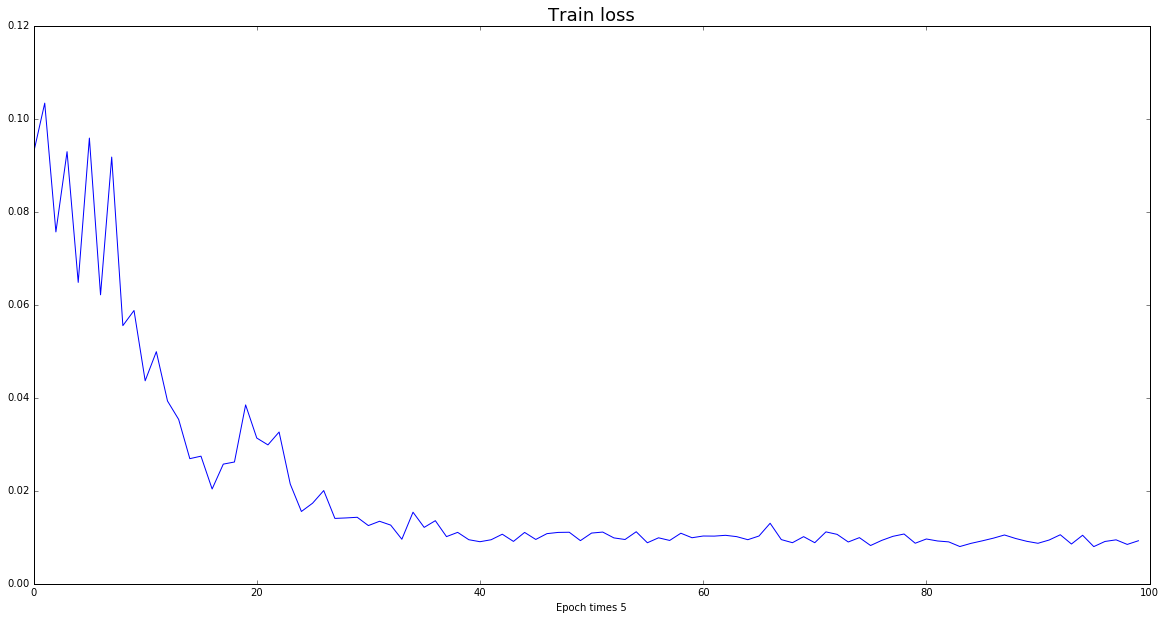

In [65]:
plt.figure(figsize=(20,10))
plt.plot(range(len(test_loss_stats)), test_loss_stats, c='b')
plt.title("Train loss", size=18)
plt.xlabel("Epoch times 5")
plt.show

## Plot embedding space after training

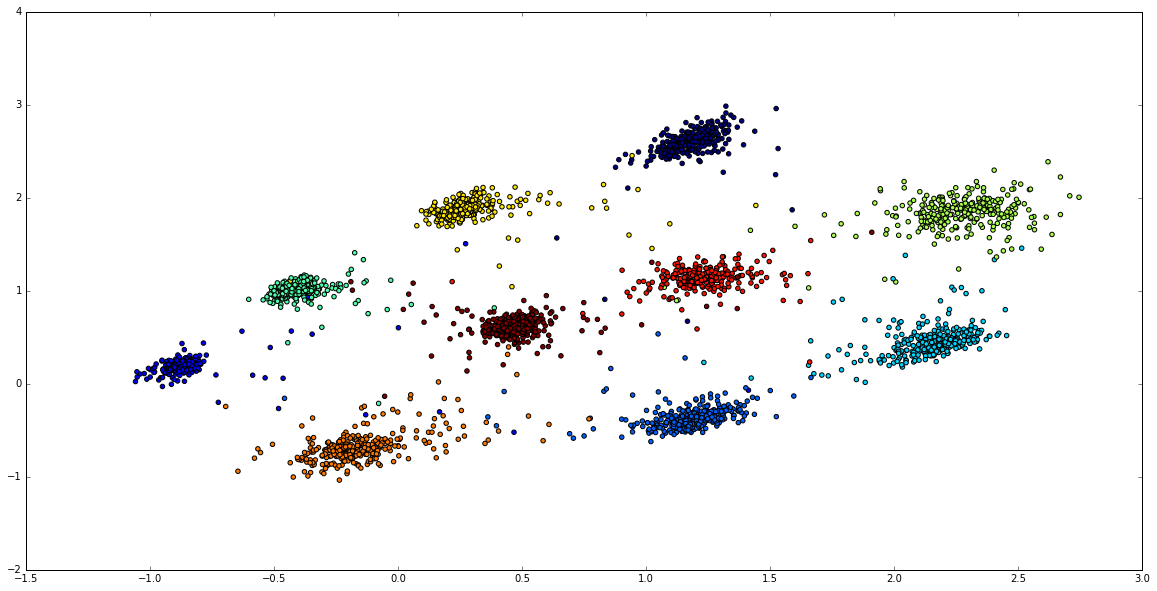

In [70]:
test_emb = forward_func(X_test)
plt.figure(figsize=(20,10))
plt.scatter(test_emb[:, 0], test_emb[:, 1], c=y_test)

# Let's check random number

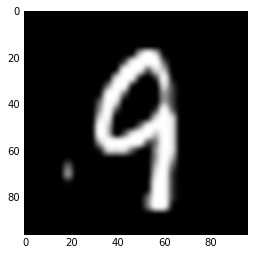

In [183]:
random_idx = np.random.choice(range(X_test.shape[0]))
im = X_test[random_idx, 0]
plt.imshow(im.reshape(HEIGHT, WIDTH), cmap=plt.cm.Greys_r)

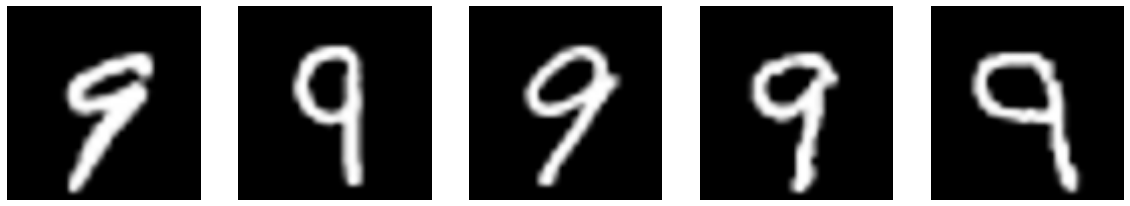

In [184]:
five_neighbors = np.ravel(cdist(test_emb[random_idx, :].reshape(-1, 2), test_emb))
five_neighbors = np.argsort(five_neighbors)[1:6]

fig = plt.figure(figsize=(20,10))
for i, idx in enumerate(five_neighbors):
    f = fig.add_subplot(1, len(five_neighbors), i + 1)
    f.set_xticklabels([])
    f.set_yticklabels([])
    plt.imshow(X_test[idx, 0], cmap=plt.cm.Greys_r)
plt.show()